# Example `KBackground.Estimator` workflow with K2 Campaign 8

In this notebook we show how to use the `KBackground` tool to estimate rolling band. You can see a video of the rolling band in this dataset [here](https://www.youtube.com/watch?v=cAc70ErIsSQ).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from kbackground import Estimator
from astropy.io import fits
from astropy.table import Table

First we are going to get a number of the TPFs in a large superstamp in campaign 8. This will let us see a patch of data with a rolling band.

In [3]:
tpfs = []
for idx in np.arange(656, 656 + 26):
    tpfs.append(lk.search_targetpixelfile(f"EPIC 200068{idx}", mission='k2').download())

Next we will extract the row, column and flux values from all the TPFs.

In [4]:
rows, columns, fluxs, mission_bkgs, cadencenos = [], [], [], [], []
for tpf in tpfs:
    column, row = np.meshgrid(np.arange(tpf.column, tpf.shape[2] + tpf.column), np.arange(tpf.row, tpf.shape[1] + tpf.row))
    aper = np.ones(tpf.shape[1:], bool)
    rows.append(row[aper])
    columns.append(column[aper])
    fluxs.append(tpf.flux.value[:, aper] + tpf.flux_bkg.value[:, aper])
    cadencenos.append(tpf.cadenceno)

Next we can build the `Estimator` object, passing in the row, column, and flux values from all the TPFs.

In [5]:
e = Estimator(cadencenos[0], np.hstack(rows), np.hstack(columns), np.hstack(fluxs))

Under the hood, `KBackground` works on the median subtracted frames, below we plot a median subtracted frame which shows a rolling band.

Text(0, 0.5, 'Row')

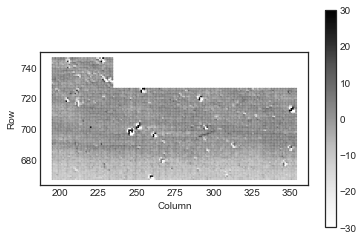

In [6]:
tdx = 870
med = e.flux[tdx] - np.median(e.flux, axis=0)
plt.scatter(np.hstack(columns), np.hstack(rows), s=1, c=med - np.median(med), vmin=-30, vmax=30)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel('Column')
plt.ylabel('Row')

We can access the model using

In [7]:
e.model

array([[-65.72157 , -65.72157 , -65.72157 , ..., -64.897575, -64.897575,
        -64.897575],
       [-65.6394  , -65.6394  , -65.6394  , ..., -64.52938 , -64.52938 ,
        -64.52938 ],
       [-65.63834 , -65.63834 , -65.63834 , ..., -64.32874 , -64.32874 ,
        -64.32874 ],
       ...,
       [423.5616  , 423.5616  , 423.5616  , ..., 423.57858 , 423.57858 ,
        423.57858 ],
       [423.65894 , 423.65894 , 423.65894 , ..., 423.7149  , 423.7149  ,
        423.7149  ],
       [424.4797  , 424.4797  , 424.4797  , ..., 422.97412 , 422.97412 ,
        422.97412 ]], dtype=float32)

This is an attribute we can index into to get a particular time-series

In [8]:
e.model[:, 1000]

array([-65.89573, -65.54416, -65.59634, ..., 423.74377, 424.3596 ,
       424.88278], dtype=float32)

We can plot the model for the same frame above.

[Text(0.5, 1.0, 'Model'), Text(0.5, 0, 'Column'), Text(0, 0.5, 'Row')]

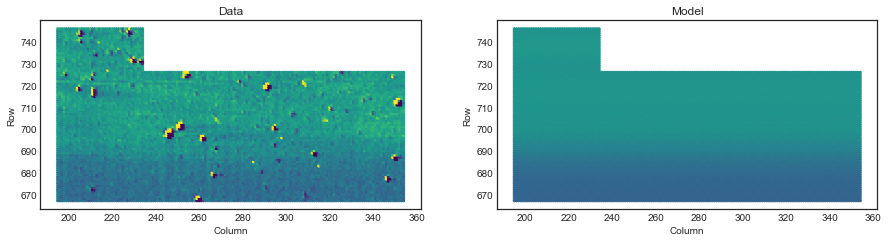

In [9]:
tdx = 890
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
med = e.flux[tdx] - np.median(e.flux, axis=0)

ax[0].scatter(np.hstack(columns), np.hstack(rows), s=5, c=(med - np.median(med))[None, :], vmin=-30, vmax=30, cmap='viridis')
ax[0].set_aspect('equal')
ax[0].set(title='Data', xlabel='Column', ylabel='Row')
ax[1].scatter(np.hstack(columns), np.hstack(rows), s=5, c=e.model[tdx] - np.median(e.model[tdx]), vmin=-30, vmax=30, cmap='viridis')
ax[1].set_aspect('equal')
ax[1].set(title='Model', xlabel='Column', ylabel='Row')

In [10]:
e.model[tdx] - med

array([-0.65447235,  1.8932266 ,  0.8631668 , ..., -0.3715248 ,
        2.4507408 ,  3.3033104 ], dtype=float32)

Text(0, 0.5, 'Flux [counts]')

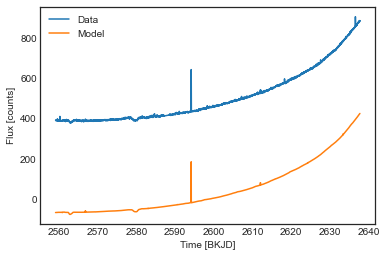

In [11]:
plt.plot(tpf.time.value, e.flux[:, 5060], label='Data')
plt.plot(tpf.time.value, e.model[:, 5060], label='Model')
plt.legend()
plt.xlabel('Time [BKJD]')
plt.ylabel('Flux [counts]')

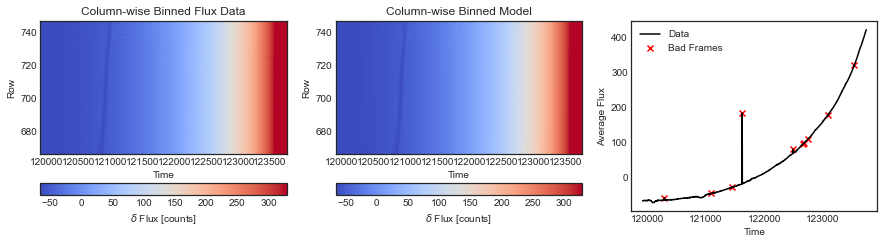

In [12]:
e.plot();

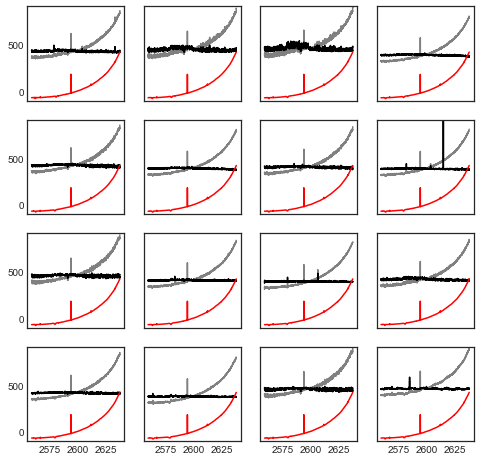

In [13]:
dim_pix = np.where(np.std(e.flux, axis=0) < np.nanpercentile(np.std(e.flux, axis=0), 20))[0]
fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
kdx = -1
for idx, jdx in enumerate(np.random.choice(dim_pix, 16)):
    if idx % 4 == 0:
        kdx += 1
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx], label='Data', c='grey')
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx] - e.model[:, jdx], label='Data', c='k')
    ax[kdx, idx % 4].plot(tpf.time.value, e.model[:, jdx], label='Model', c='r')
    ax[kdx, idx % 4].set(ylim=(-100, ax[kdx, idx % 4].get_ylim()[1]))